In [1]:
#% shift enter to run section
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
import numpy as np
import numpy.ma as ma
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.style.use('ggplot')
import xarray as xr
from glob import glob
import netCDF4
from netCDF4 import Dataset
import matplotlib.mlab as mlab
import pylab
import pyreadr
import seaborn as sns
import tqdm
import tzlocal
import sys
import os
import scipy.interpolate as sc
from scipy import signal
my_timezone = tzlocal.get_localzone().zone
# pylab for more MATLAB like environment and inline displays plots below cells
%pylab inline

# if gsw Warning shows, manually install gsw if possible - will still work without
import glidertools as gt
from cmocean import cm as cmo  # we use this for colormaps
#del()
import geostatspy.GSLIB as GSLIB 
import geostatspy.geostats as geostats 
import scipy.stats   
from skgstat import Variogram
import pykrige

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

from sklearn.linear_model import LinearRegression
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
readRDS = robjects.r['readRDS']

Populating the interactive namespace from numpy and matplotlib


C:\Users\Sean Evans\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load data
Remember to insert the seal id number to read in data for that seal

In [2]:
number = 1
flr_gridded_xds = xr.open_dataarray('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Gridded_Temp_TimeSeries/'+str(number)+'_flr_gridded_xds.nc')
Nt_xds = xr.open_dataarray('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Nt_xds/'+str(number)+'_Nt_xds.nc')
divestats = pd.read_csv('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/divessummary.csv')

lat_coords = divestats[(divestats['all.dur']>60) & (divestats['max.d']>4)].lat.values
lon_coords = divestats[(divestats['all.dur']>60) & (divestats['max.d']>4)].lon.values
dist_trav = np.r_[gt.utils.distance(lon_coords, lat_coords).cumsum()]/1000

# Horizontal interpolation (Kriging)
Temp

## Interpolation setup

In [3]:
flr_gridded_xds.values

array([[5.8 , 5.3 , 5.55, ..., 5.55, 5.55, 5.55],
       [5.8 , 5.3 , 5.55, ..., 5.55, 5.55, 5.55],
       [5.8 , 5.3 , 5.55, ..., 5.55, 5.55, 5.55],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [4]:
#%% Distance travelled plot

#lat = np.array(Down_init['lat'])*-1
#lon = np.array(Down_init['lon'])
#dist_travelled = np.r_[gt.utils.distance(lon, lat).cumsum()]/1000
#dist_between = np.r_[gt.utils.distance(lon, lat)]/1000

b_init_groups = flr_gridded_xds.assign_coords(dist_trav=("Time", dist_trav)) 
b_init = b_init_groups.groupby("dist_trav").reduce(nanmean,dim='Time')
#b_init.groupby("loc_coords").mean(dim="Time")
#b_init_groups.groupby("dist_trav").groups

In [5]:
xi = arange(0.5,ceil(b_init.dist_trav.values.max()),1) # 5km resolution
yi = arange(1,201,1).astype(numpy.float64)
points_dist_trav = np.tile(np.expand_dims(b_init.dist_trav,axis=1),(1,200)).ravel()
points_depths = np.tile(np.expand_dims(b_init.depths,axis=0),(1,b_init.shape[1])).ravel()
values = b_init.values.ravel(order='F')
#new_hbg_init = gt.grid_data(points_depths,points_dist_trav,values,bins=xi)

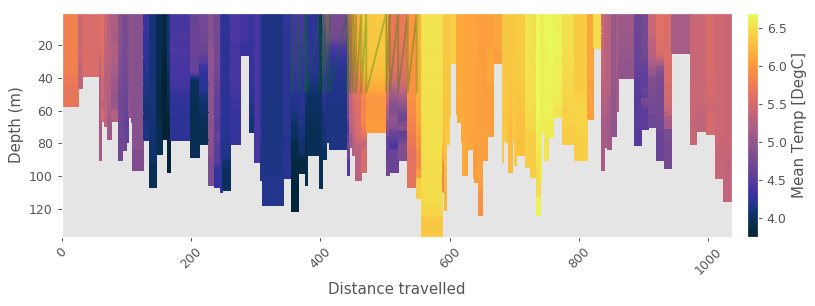

In [6]:
# Choose m section OR skip this section and plot below without ' mask=m' 
m = (points_depths < 50) & (points_dist_trav > 350) & (points_dist_trav < 550)
ax = gt.plot(points_dist_trav, points_depths, values, cmap=cmo.thermal)
ax.plot(points_dist_trav[m], points_depths[m], '-m', ms=3, alpha=0.3, c='green')
ax.cb.set_label('Mean Temp [DegC]')
plt.xlabel('Distance travelled')

plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/Dist_trav_before_interpolation.png', dpi=300)

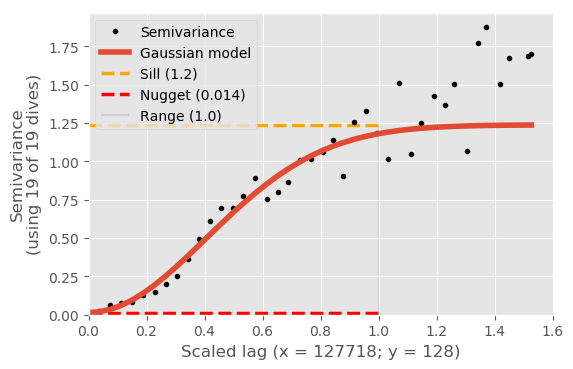

In [7]:
hor_scale = diff(xi)[0]*1000
vert_scale = diff(yi)[0]
points_dives = np.tile(np.expand_dims(arange(1,len(unique(points_dist_trav))+1,1).astype(numpy.float64),axis=1),(1,200)).ravel()
vargram = gt.mapping.variogram(values, points_dist_trav*1000, points_depths, points_dives, mask=m, xy_ratio=vert_scale/hor_scale)
plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/Variogram.png', dpi=300)

In [8]:
interpolated = gt.mapping.interp_obj(points_dist_trav, points_depths, values, xi, yi,
    # Kriging interoplation arguments
    partial_sill=list(vargram[0].items())[0][1],  # taken from the semivariogram (sill - nugget)
    nugget=list(vargram[0].items())[1][1],  # taken from the semivariogram
    lenscale_x=list(vargram[0].items())[2][1],  # in hours if x and xi are in datetime64
    lenscale_y=list(vargram[0].items())[3][1],  # the vertical gridding influence
    detrend=True,  # if True use linear regression (z - z_hat), if False use average (z - z_mean)

    # Quadtree arguments
    max_points_per_quad=100,  # an optimsation setting ~100 is good
    min_points_per_quad=10,  # if neighbours have < N points, look at their neighbours

    # Parallel calculation inputs.
    n_cpus=4,  # the number of CPU's to use for the calculation - default is n-1
    parallel_chunk_size=512,  # when the dataset is very large, memory can become an issue
                              # this prevents large buildup of parallel results)
)

Starting Interpolation with quadtree optimal interpolation
----------------------------------------------------------

Preparing for interpolations:
	Finding and removing nans
	Removing data trend with linear regression
	Building QuadTree

Interpolation information:
	basis points:        8597
	interp grid:         1037, 200
	max_points_per_quad: 100
	min_points_per_quad: 10
	number of quads:     196
	detrend_method:      linear_regression
	partial_sill:        1.2231699868123032
	nugget:              0.014082507992619118
	lengthscales:        X = 127718.32898494409 
	                     Y = 127.7183289849441 m

Processing interpolation in 1 parts over 4 CPUs:
	chunk 1/1 completed in 22s

Finishing off interoplation
	Adding back the trend
	Creating xarray dataset for output


C:\Users\Sean Evans\Anaconda3\lib\site-packages\glidertools\helpers.py:69: GliderToolsWarning:

Primary input variable is not xr.DataArray data type - no metadata to pass on.



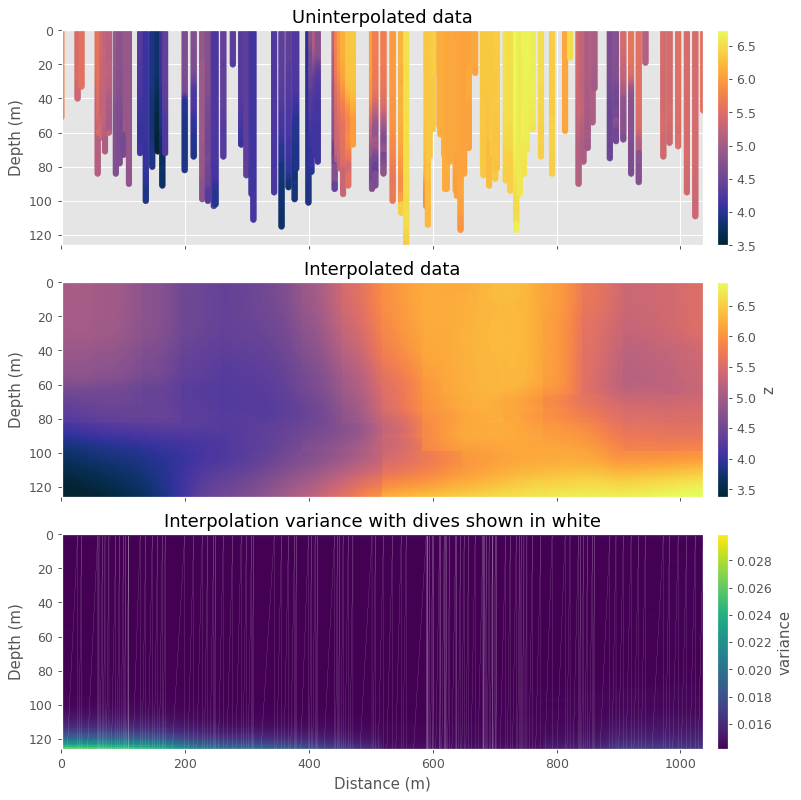

In [9]:
fig, ax = plt.subplots(3, 1, figsize=[9, 9], sharex=True, dpi=90)

interp_robust_T = interpolated.z

props = dict(cmap=cmo.thermal)
gt.plot.scatter(points_dist_trav,points_depths,values, s=1.5, ax=ax[0], **props)
gt.plot.pcolormesh(interp_robust_T, ax=ax[1], **props)
gt.plot.pcolormesh(interpolated.variance, ax=ax[2])

ax[2].plot(points_dist_trav, points_depths, 'w-', zorder=40, alpha=0.8, lw=0.1)

[a.set_ylim(round(divestats['max.d'].max(),0), 0) for a in ax]
[a.set_xlabel('  ') for a in ax]

ax[0].get_children()[0].set_sizes([20])
ax[0].set_title('Uninterpolated data')
ax[1].set_title('Interpolated data')
ax[2].set_title('Interpolation variance with dives shown in white')
ax[2].set_xlabel('Distance (m)')

tks = xticks(rotation=0)

In [22]:
interp_robust_T.to_netcdf('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/interp_robust/'+str(number)+'_interp_robust.nc')

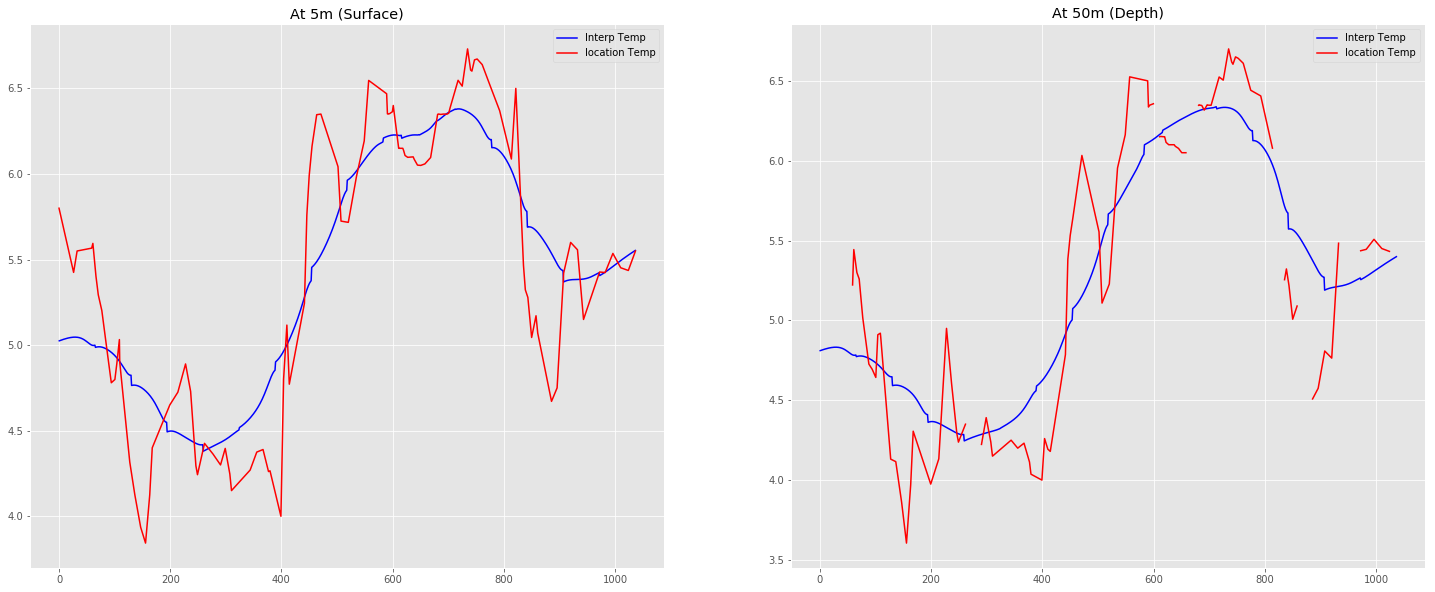

In [10]:
# Is the interpolation too smpooth i.e. losing the submesoscale variability?
fig = plt.figure(figsize=(25, 10))

ax1 = fig.add_subplot(1,2,1)
#plt.subplot(1,2,1)
plt.plot(interp_robust_T[5,:].x.values,interp_robust_T[5,:],'blue', label='Interp Temp')
plt.plot(b_init[5,:].dist_trav.values,b_init[5,:],'red', label='location Temp')
plt.legend()
plt.title('At 5m (Surface)')

ax2 = fig.add_subplot(1,2,2)
#plt.subplot(1,2,2)
plt.plot(interp_robust_T[5,:].x.values,interp_robust_T[50,:],'blue', label='Interp Temp')
plt.plot(b_init[5,:].dist_trav.values,b_init[50,:],'red', label='location Temp')
plt.legend()
plt.title('At 50m (Depth)')

fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/Interp_validation.png', dpi=300)

# hbg Calculation
i.e. Horizontal buoyancy gradient 

In [11]:
def calc_hbg(var):

    """Calculate hbg

    Args:
      var: Temperature 

    Return:
        hbg for each profile and at each depth based on lateral temperature difference

    Dependencies:
        numpy

    """
    import numpy as np
    hbg=[]
    hbg_mean = []

    try:
        T_diff = diff(var)/diff(dpt)
        Hbg = T_diff*(g*alpha)
        hbg += Hbg,
        hbg_mean = np.nanmean(Hbg)
    except:
        hbg += np.NaN,
        hbg_mean = np.NaN

    return np.array(hbg,hbg_mean)

### Per dive (Time or Dive on x-axis)

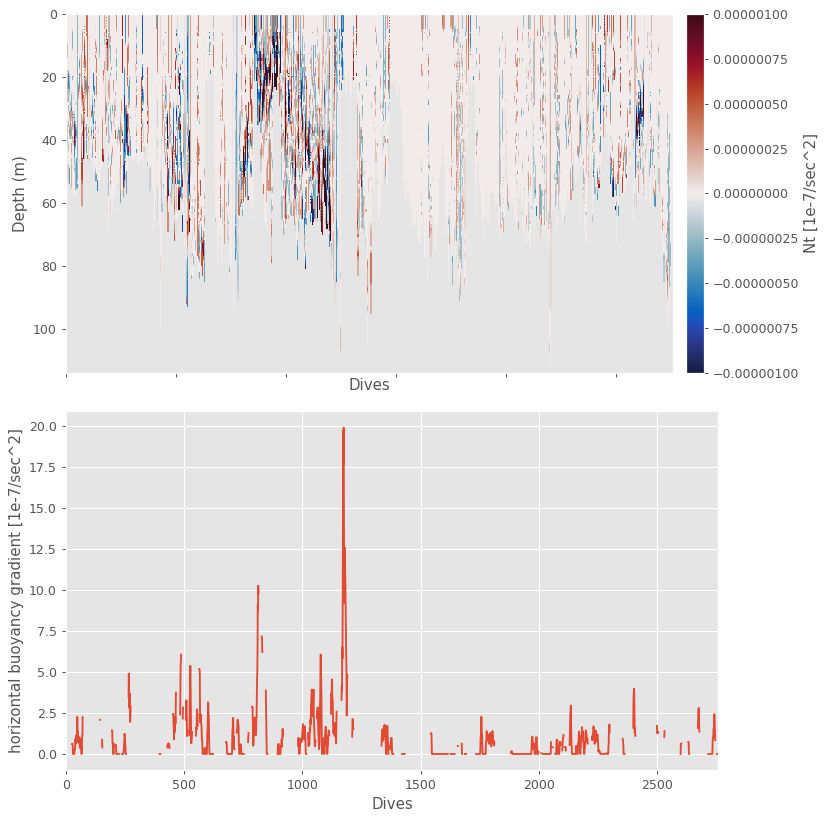

In [12]:
#%% Each dive/Time hbg

# Check if there is correlation between hbg and ht_rat and fsle. Do this for 50m, 5m, water column mean and 15m from max.d

g = 9.8
alpha = -0.000125
dpt = flr_gridded_xds.Time.values
hbg = np.apply_along_axis(calc_hbg,1,flr_gridded_xds)
hbg = hbg.squeeze()

fig, ax = plt.subplots(2, 1, figsize=[9, 9], sharex=True, dpi=90)

gt.plot(hbg, cmap = cmo.balance, ax=ax[0], vmin=-1e-6,vmax=1e-6)
plt.xlabel('Dives')
ax[0].cb.set_label('Nt [1e-7/sec^2]')


def movingaverage(interval, window_size):
    window= numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

HBG = movingaverage(abs(hbg[50,:]*1e7),5)
ax[1].plot(HBG) # ~50 is the mean max.d for seal 31
plt.xlabel('Dives')
plt.ylabel('horizontal buoyancy gradient [1e-7/sec^2]')

plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/hbg_5km_krig.png', dpi=300)

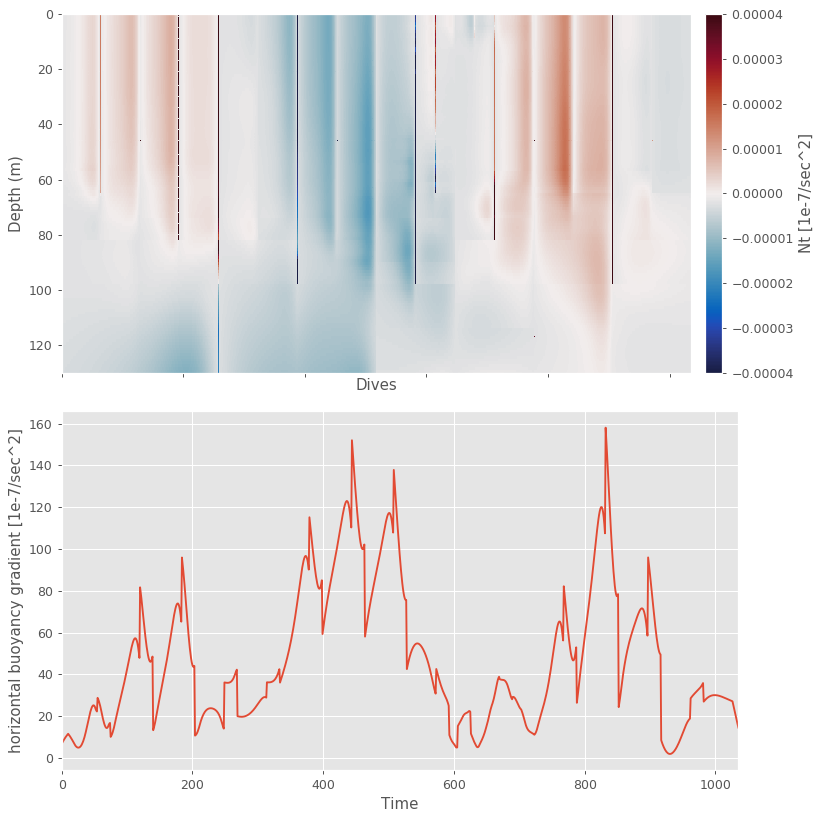

In [13]:
#%% hbg using interpolated temp at 1km

#Redo x-axis so that seq(0,max(dist_trav),5)
#plt.plot(divestats max )
g = 9.8
alpha = -0.000125
dpt = interp_robust_T.x.values
hbg = np.apply_along_axis(calc_hbg,1,interp_robust_T)
hbg = hbg.squeeze()

fig, ax = plt.subplots(2, 1, figsize=[9, 9], sharex=True, dpi=90)

gt.plot(hbg, cmap = cmo.balance, ax=ax[0], vmin=-0.00004,vmax=0.00004)
#plt.ylim(mean(divestats['max.d']),0)
plt.xlabel('deltax = 1km')
ax[0].cb.set_label('Nt [1e-7/sec^2]')

HBG = movingaverage(abs(hbg[5,:]*1e7),20)
ax[1].plot(HBG) # ~50 is the mean max.d for seal 31
plt.xlabel('Time')
plt.ylabel('horizontal buoyancy gradient [1e-7/sec^2]')

plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/hbg_interp1km_krig.png', dpi=300)

# Location dive summaries

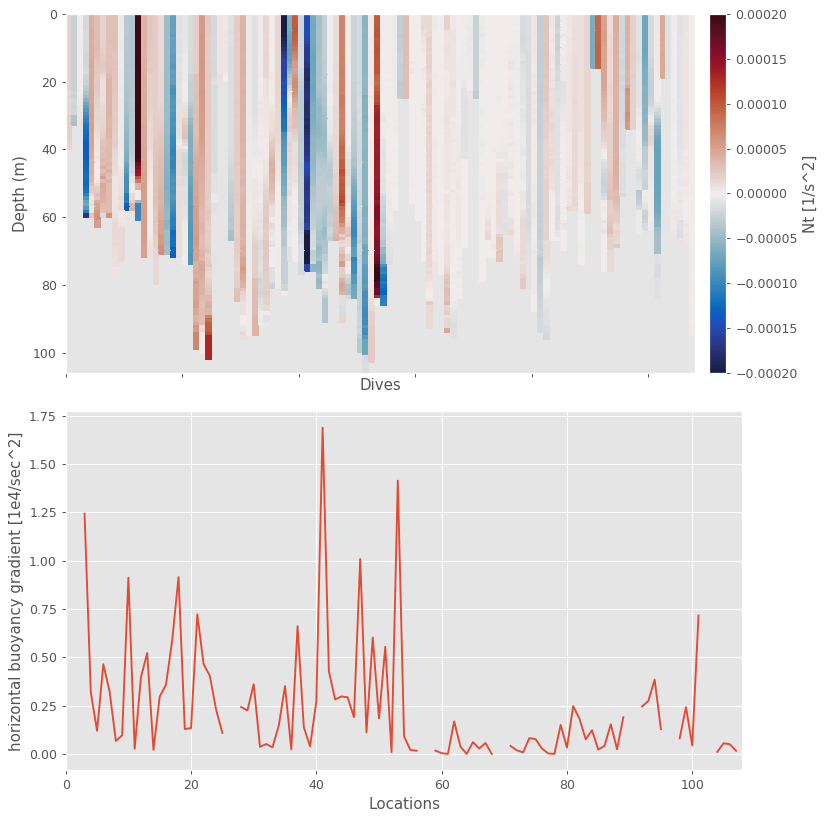

In [14]:
#%% Location means of hbg
g = 9.8
alpha = -0.000125
dpt = b_init.dist_trav.values
hbg = np.apply_along_axis(calc_hbg,1,b_init)
hbg = hbg.squeeze()

fig, ax = plt.subplots(2, 1, figsize=[9, 9], sharex=True, dpi=90)

gt.plot(hbg, cmap = cmo.balance, ax=ax[0], vmin=-0.00020,vmax=0.00020)
plt.xlabel('Each location mean')
ax[0].cb.set_label('Nt [1/s^2]')

ax[1].plot(abs(hbg[50,:]*1e4))
plt.xlabel('Locations')
plt.ylabel('horizontal buoyancy gradient [1e4/sec^2]')

plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/hbg_locs.png', dpi=300)

NameError: name 'fsle_' is not defined

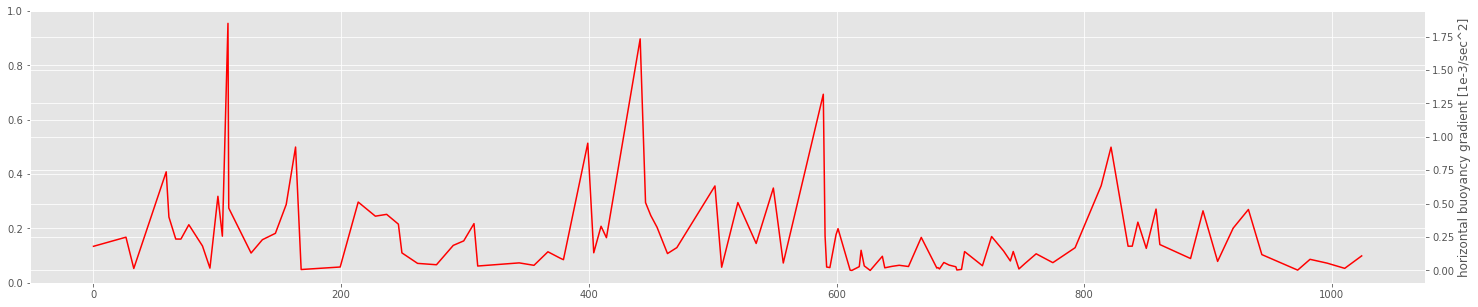

In [15]:
fig = plt.figure(figsize=(25, 5))

HBG = movingaverage(abs(hbg[5,:]*1e7),20)

axis = plt.twinx()

axis.plot(unique(dist_trav)[0:109],abs(np.apply_along_axis(nanmean,0,hbg)*1e4), c='red') # ~50 is the mean max.d for seal 31
#axis.plot(unique(dist_trav),divestats.groupby('X').apply(lambda x: nanmean(x['deltaT'])), c='purple')
plt.ylabel('horizontal buoyancy gradient [1e-3/sec^2]')
#plt.xlabel('Time')

axis.plot(dist_trav,movingaverage(fsle_*-1,5),c='g')
plt.ylabel('fsle [days-1]')

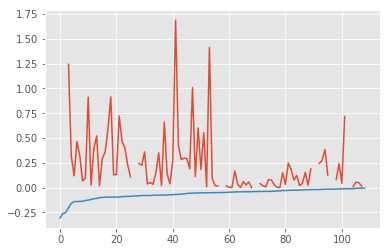

In [378]:
plt.plot(arange(0,109,1),abs(hbg[50,:]*1e4))
plt.plot(arange(0,109,1),unique(fsle_)[0:109])

# Ri
Balanced Richardson number - Criterion to indicate presence of submesoscale processes.
(N2*f2)/M4
Buoyancy term/flow shear term.
When Ri is large, turbulent mixing across the stratification is generally suppressed and buoyancy dominates.
Relative importance of mechanical and density effects in the water column.

In [ ]:
f = -1*1e-4
hbg_sq = square(np.apply_along_axis(nanmean,0,hbg[arange(0,199,1),:]))
Nt_xds_sq4 = square(square(np.apply_along_axis(nanmean,0,Nt_xds.isel(time=arange(0,2759,1)))))

In [ ]:
gt.plot((square(hbg[arange(0,199,1),:])*square(f)/square(square(Nt_xds.isel(time=arange(0,2759,1))))),vmin=0,vmax=1)

gt.plot((hbg_sq*square(f)/square(square(Nt_xds.isel(time=arange(0,2759,1))))),vmin=0,vmax=1)

# Horizontal interpolation (Kriging)
Nt

In [18]:
Nt_init_groups = Nt_xds.assign_coords(dist_trav=("time", dist_trav)) 
Nt_init = Nt_init_groups.groupby("dist_trav").reduce(nanmean,dim='time')

In [19]:
xi = arange(0.5,ceil(Nt_init.dist_trav.values.max()),1) # 5km resolution
yi = arange(1,201,1).astype(numpy.float64)
points_dist_trav = np.tile(np.expand_dims(Nt_init.dist_trav,axis=1),(1,199)).ravel()
points_depths = np.tile(np.expand_dims(Nt_init.depth,axis=0),(1,Nt_init.shape[1])).ravel().astype(numpy.float64)
values = Nt_init.values.ravel(order='F')
#new_hbg_init = gt.grid_data(points_depths,points_dist_trav,values,bins=xi)

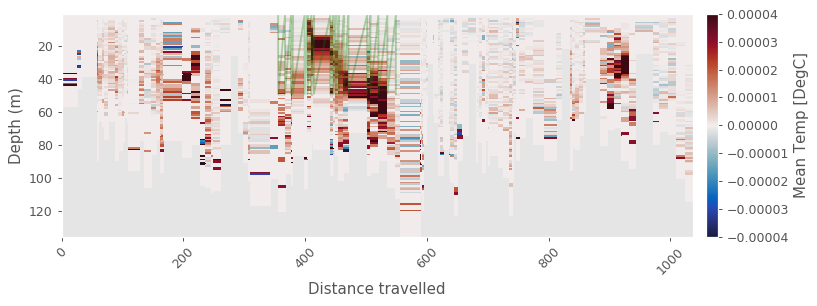

In [20]:
# Choose m section OR skip this section and plot below without ' mask=m' 
m = (points_depths<50) & (points_dist_trav > 350) & (points_dist_trav < 550)
ax = gt.plot(points_dist_trav, points_depths, values, cmap=cmo.balance, vmin=-0.00004,vmax=0.00004)
ax.plot(points_dist_trav[m], points_depths[m], '-m', ms=3, alpha=0.3, c='green')
ax.cb.set_label('Mean Temp [DegC]')
plt.xlabel('Distance travelled')

plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/Dist_trav_before_interpolation.png', dpi=300)

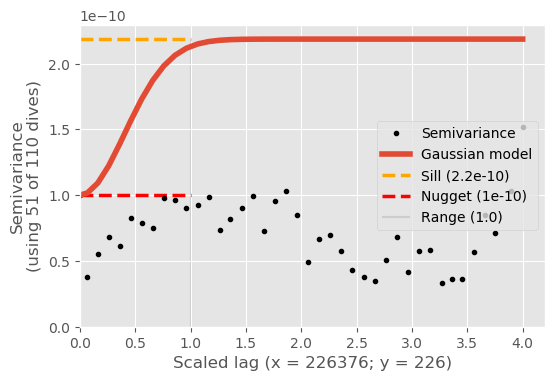

In [21]:
hor_scale = diff(xi)[0]*1000
vert_scale = diff(yi)[0]
points_dives = np.tile(np.expand_dims(arange(1,len(unique(points_dist_trav))+1,1).astype(numpy.float64),axis=1),(1,199)).ravel()
vargram = gt.mapping.variogram(values, points_dist_trav*1000, points_depths, points_dives, xy_ratio=vert_scale/hor_scale)
plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/Profiles/Variogram1.png', dpi=300)

In [22]:
interpolated = gt.mapping.interp_obj(points_dist_trav, points_depths, values, xi, yi,
    # Kriging interoplation arguments
    partial_sill=list(vargram[0].items())[0][1],  # taken from the semivariogram (sill - nugget)
    nugget=list(vargram[0].items())[1][1],  # taken from the semivariogram
    lenscale_x=list(vargram[0].items())[2][1],  # in hours if x and xi are in datetime64
    lenscale_y=list(vargram[0].items())[3][1],  # the vertical gridding influence
    detrend=True,  # if True use linear regression (z - z_hat), if False use average (z - z_mean)

    # Quadtree arguments
    max_points_per_quad=100,  # an optimsation setting ~100 is good
    min_points_per_quad=10,  # if neighbours have < N points, look at their neighbours

    # Parallel calculation inputs.
    n_cpus=4,  # the number of CPU's to use for the calculation - default is n-1
    parallel_chunk_size=512,  # when the dataset is very large, memory can become an issue
                              # this prevents large buildup of parallel results)
)

Starting Interpolation with quadtree optimal interpolation
----------------------------------------------------------

Preparing for interpolations:
	Finding and removing nans
	Removing data trend with linear regression
	Building QuadTree

Interpolation information:
	basis points:        8487
	interp grid:         1037, 200
	max_points_per_quad: 100
	min_points_per_quad: 10
	number of quads:     193
	detrend_method:      linear_regression
	partial_sill:        1.1860831245147205e-10
	nugget:              1e-10
	lengthscales:        X = 226376.3035210949 
	                     Y = 226.3763035210949 m

Processing interpolation in 1 parts over 4 CPUs:
	chunk 1/1 completed in 21s

Finishing off interoplation
	Adding back the trend
	Creating xarray dataset for output


C:\Users\Sean Evans\Anaconda3\lib\site-packages\glidertools\helpers.py:69: GliderToolsWarning:

Primary input variable is not xr.DataArray data type - no metadata to pass on.



# HBG Interpolated

(-6.269243332757932, 131.65410998791657)

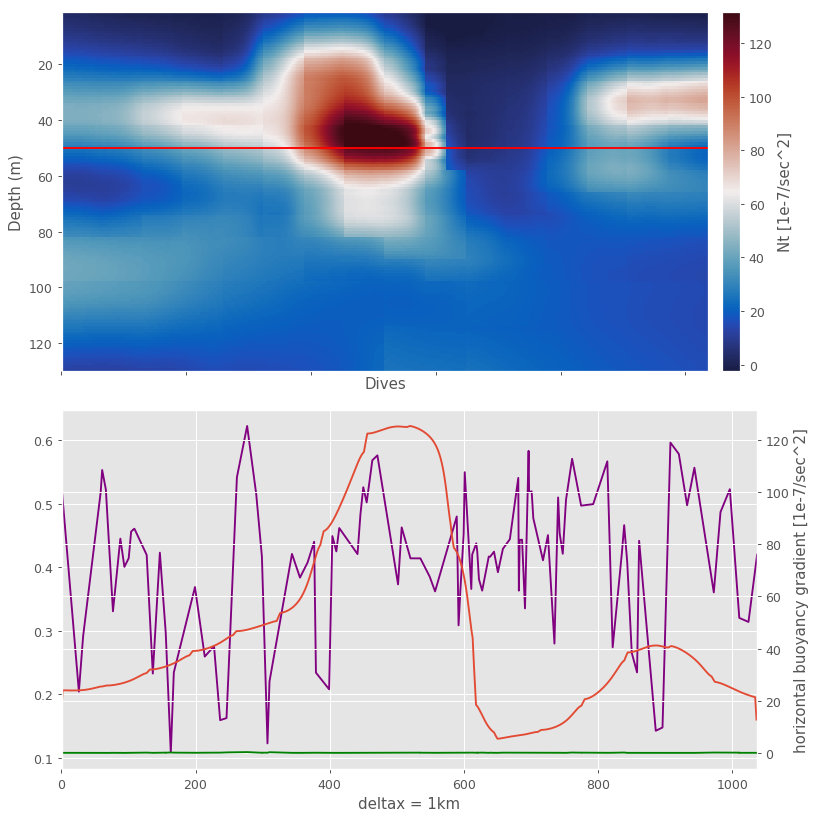

In [30]:
#%% hbg interpolated

interp_robust_hbg = interpolated.z

fig, ax = plt.subplots(2, 1, figsize=[9, 9], sharex=True, dpi=90)

gt.plot(interp_robust_hbg*1e7, cmap = cmo.balance, ax=ax[0])
ax[0].hlines(50,0,interp_robust_hbg.shape[1], colors='r')
#plt.ylim(mean(divestats['max.d']),0)
plt.xlabel('deltax = 1km')
ax[0].cb.set_label('Nt [1e-7/sec^2]')

#HBG = movingaverage(abs(interp_robust_hbg[50,:]*1e7),20)
#ax[1].plot(HBG) # ~50 is the mean max.d for seal 31
#ax[1].plot(unique(dist_trav),divestats.groupby('X').apply(lambda x: nanmean(x['ht_rat'])))
#plt.xlabel('Time')
#plt.ylabel('horizontal buoyancy gradient [1e-7/sec^2]')

axis = ax[1].twinx()
HBG = movingaverage(abs(interp_robust_hbg[50,:]*1e7),5)
#ax[1].plot(HBG, c='red') # ~50 is the mean max.d for seal 31
ax[1].plot(unique(dist_trav),divestats.groupby('X').apply(lambda x: nanmean(x['ht_rat'])), c='purple')
plt.xlabel('Time')
plt.ylabel('horizontal buoyancy gradient [1e-7/sec^2]')
axis.plot(dist_trav,fsle_*-1,c='g')
axis.plot(HBG)
axis.set_ylim()
#axis.plot(unique(dist_trav),divestats.groupby('X').apply(lambda x: nanmean(x['deltaT'])), c='purple')
#plt.yticks([])

In [317]:
divestats.columns

Index(['num', 'mean_cor_depth', 'mean_Temp', 'deltaT', 'max.d', 'hunt_dive',
       'transit_time', 'Mvdist_err_transit', 'Mdepth_transit', 'hunting_time',
       'Mvdist_err_hunting', 'Mdepth_hunting', 'External.Temp', 'sealID',
       'species', 'beach', 'Temp_int', 'Season', 'seal_tag', 'TDR/SPLASH',
       'all.dur', 'bottom_depth', 'bottom_time', '%bt/dt', 'pdsi', 'end',
       'dive_efficiency', 'X', 'lon', 'lat', 'local_time', 'JDay', 'sunrise',
       'sunset', 'dawn', 'dusk', 'mirror.time', 'diel_phase', 'hour', 'ht_rat',
       'distances [m]', 'start', 'therm_strength', 'Therm_dep', 'Tmld',
       'Thermocline', 'Nt'],
      dtype='object')

## Add fsle to graph

In [24]:
flse_file = xr.open_dataset("C:/Users/Sean Evans/Documents/2020/MSc/Data/AVISO eddy tracking & fsle/fsle/seal1_VDB_2009W_0890438_GW522/dataset-duacs-dt-global-allsat-madt-fsle_1596196018265.nc")
flse_file = flse_file.sel(lon=slice(35, 45),lat=slice(-52, -43))
fsle_seal1_mean = np.apply_along_axis(mean,0,flse_file['fsle_max'])
fsle_day1_seal1 = flse_file['fsle_max'][0]
fsle_day12_seal1 = flse_file['fsle_max'][12]
fsle_day25_seal1 = flse_file['fsle_max'][25]

In [140]:
number = 1
divestats = pd.read_csv('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/divessummary.csv')#,index_col=0)

In [141]:
fig = plt.subplots(figsize=(50, 20),dpi=300)

ax1 = plt.subplot(2, 2, 1)
plt.pcolormesh(flse_file['fsle_max'].lon.values, flse_file['fsle_max'].lat.values, fsle_seal1_mean,cmap=cmo.matter, vmax=0, vmin=-0.5)
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.plot(divestats.lon,divestats.lat,color='w')
plt.colorbar(extend='both').set_label('fsle [days-1]')
plt.xlabel('lon', fontsize=25)
plt.ylabel('lat', fontsize=25)
plt.title('Mean fsle for seal1 all days',fontsize=40)

ax2 = plt.subplot(2, 2, 2)
plt.pcolormesh(fsle_day1_seal1.lon.values, fsle_day1_seal1.lat.values, fsle_day1_seal1,cmap=cmo.speed, vmax=0, vmin=-0.5)
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.plot(divestats.lon,divestats.lat,color='w')
plt.colorbar(extend='both').set_label('fsle [days-1]')
plt.xlabel('lon', fontsize=25)
plt.ylabel('lat', fontsize=25)
plt.title('Mean fsle for seal1 day 1',fontsize=40)

ax3 = plt.subplot(2, 2, 3)
plt.pcolormesh(fsle_day12_seal1.lon.values, fsle_day12_seal1.lat.values, fsle_day12_seal1,cmap=cmo.speed, vmax=0, vmin=-0.5)
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.plot(divestats.lon,divestats.lat,color='w')
plt.colorbar(extend='both').set_label('fsle [days-1]')
plt.xlabel('lon', fontsize=25)
plt.ylabel('lat', fontsize=25)
plt.title('Mean fsle for seal1 day 12',fontsize=40)

ax4 = plt.subplot(2, 2, 4)
plt.pcolormesh(fsle_day25_seal1.lon.values, fsle_day25_seal1.lat.values, fsle_day25_seal1,cmap=cmo.speed, vmax=0, vmin=-0.5)
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.plot(divestats.lon,divestats.lat,color='w')
plt.colorbar(extend='both').set_label('fsle [days-1]')
plt.xlabel('lon', fontsize=25)
plt.ylabel('lat', fontsize=25)
plt.title('Mean fsle for seal1 day 25',fontsize=40)

plt.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/Seal'+str(number)+'/ARS/fsle.png', dpi=300)

In [25]:
Nt_xds_local_time_start = pd.to_timedelta(Nt_xds.time.values + 7200, unit='s') + pd.to_datetime('1970-01-01')

for i in tqdm_notebook(list(range(len(Nt_xds_local_time_start)))):
    fsle_day = flse_file.sel(time=pd.to_datetime(Nt_xds_local_time_start[i].strftime("%Y %m %d"))).sel(lat=slice(lat_coords[i]-0.04,lat_coords[i]+0.04)).sel(lon=slice(lon_coords[i]-0.04,lon_coords[i]+0.04))['fsle_max'] 
    fsle_day = fsle_day.values.mean()
    if i == 0:
        fsle_ = fsle_day
    else: 
        fsle_ = np.append(fsle_,fsle_day)

In [26]:
fsle_day = flse_file.sel(time=pd.to_datetime(Nt_xds_local_time_start[800].strftime("%Y %m %d"))).sel(lat=slice(lat_coords[10]-0.1,lat_coords[10]+0.1)).sel(lon=slice(lon_coords[10]-0.1,lon_coords[10]+0.1))['fsle_max']

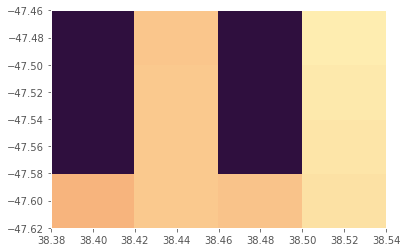

In [237]:
plt.pcolormesh(fsle_day.lon.values, fsle_day.lat.values, fsle_day.values,cmap=cmo.matter)

In [276]:
fsle_day = flse_file.sel(time=pd.to_datetime(Nt_xds_local_time_start[800].strftime("%Y %m %d")))

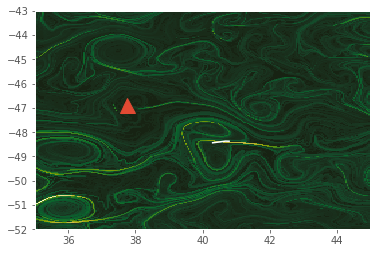

In [314]:
plt.pcolormesh(fsle_day.lon.values, fsle_day.lat.values, fsle_day['fsle_max'].values,cmap=cmo.speed) #, vmax=0, vmin=-0.5
plt.plot(37.73555555555556,-46.8886111,"^",ms=15)
plt.plot(divestats.lon[np.where(fsle_==min(fsle_))[0][0]-20:np.where(fsle_==min(fsle_))[0][-1]+20].values,divestats.lat[np.where(fsle_==min(fsle_))[0][0]-20:np.where(fsle_==min(fsle_))[0][-1]+20].values,color='w')